In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
# ------------------------------------------------------------
# SETUP: Simulation Parameters and Scenario Definitions
# ------------------------------------------------------------

# Seed the random number generator for reproducibility
np.random.seed(42)

# Time range for forecasting
years = np.arange(2025, 2051)
num_samples = 10000  # Monte Carlo iterations per year

# Baseline input values (initial year = 2025)
e_current_mean = 1e6             # Average server electricity consumption (kWh/day)
e_current_std = 1e5              # Standard deviation of energy use

rho_s1_current = 1.8             # WUE (litres of cooling water per kWh)
theta_current = 1.2              # PUE (total energy / IT energy)
rho_s2_current = 1.5             # EWIF (litres per kWh in electricity generation)
embodied_water_annual_current = 1e8  # Embodied water (litres/year)
T0 = 365                         # Equipment lifespan (in days)

# Annual efficiency improvements (e.g., due to new tech)
rho_s1_improvement = 0.005       # 0.5% annual reduction in WUE
theta_improvement = 0.005        # 0.5% annual improvement in PUE
rho_s2_improvement = 0.01        # 1% reduction in EWIF
embodied_improvement = 0.01      # 1% improvement in EWU

# Scenario-specific compute growth rates
scenarios_growth = {
    'Business-as-usual': 0.10,
    'Moderate intervention': 0.05,
    'Sustainable transformation': 0.00
}

# Storage containers for results (posterior means and credible intervals)
posterior_means = {scenario: [] for scenario in scenarios_growth}
posterior_lowers = {scenario: [] for scenario in scenarios_growth}
posterior_uppers = {scenario: [] for scenario in scenarios_growth}

# ------------------------------------------------------------
# SIMULATION: Monte Carlo Estimation per Scenario and Year
# ------------------------------------------------------------

for scenario, growth_rate in scenarios_growth.items():
    for year in years:
        t = year - 2025  # Years since base year

        # Sample energy demand using Gaussian prior
        e_samples = np.random.normal(e_current_mean, e_current_std, num_samples)
        e_future = e_samples * ((1 + growth_rate) ** t)  # Forecast future energy

        # Time-evolving efficiency parameters
        rho_s1_t = rho_s1_current * ((1 - rho_s1_improvement) ** t)
        theta_t = theta_current * ((1 - theta_improvement) ** t)
        rho_s2_t = rho_s2_current * ((1 - rho_s2_improvement) ** t)
        embodied_annual_t = embodied_water_annual_current * ((1 - embodied_improvement) ** t)

        # Convert annual embodied water to daily values (billion litres/day)
        W_embodied_t = (embodied_annual_t / T0) / 1e9

        # Compute total operational water usage
        W_onsite = e_future * rho_s1_t / 1e9           # On-site water
        W_offsite = e_future * theta_t * rho_s2_t / 1e9  # Off-site electricity-related water
        W_total = W_onsite + W_offsite + W_embodied_t   # Total daily water footprint

        # Store posterior mean and 90% credible interval
        posterior_means[scenario].append(np.mean(W_total))
        lower, upper = np.percentile(W_total, [5, 95])
        posterior_lowers[scenario].append(lower)
        posterior_uppers[scenario].append(upper)

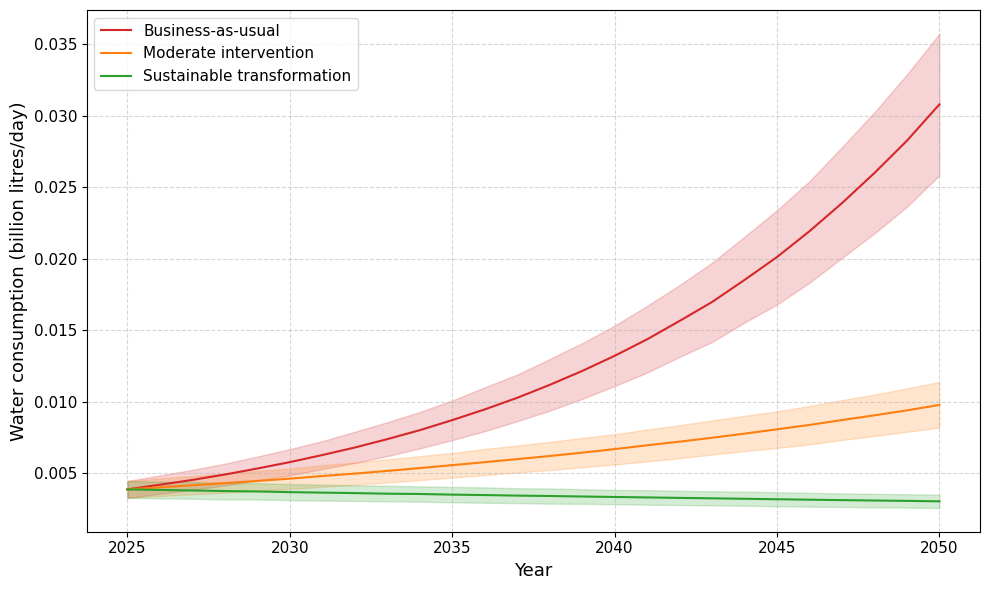

In [10]:
# ------------------------------------------------------------
# VISUALISATION: Forecast Plot for All Scenarios
# ------------------------------------------------------------

plt.figure(figsize=(10, 6))

for scenario, color in zip(scenarios_growth.keys(), ['tab:red', 'tab:orange', 'tab:green']):
    plt.plot(years, posterior_means[scenario], label=scenario, color=color)
    plt.fill_between(years, posterior_lowers[scenario], posterior_uppers[scenario], color=color, alpha=0.2)

# Add labels and legend
plt.xlabel("Year", fontsize=13)
plt.ylabel("Water consumption (billion litres/day)", fontsize=13)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()

# Optional: Save plot to file
# plt.savefig("forecast_water_use.pdf", dpi=600)
plt.show()

In [7]:
# ------------------------------------------------------------
# SENSITIVITY ANALYSIS (Summary Table Generation)
# ------------------------------------------------------------

# Assumed baseline for comparison
baseline = 28.11  # billion litres/day (2050, business-as-usual)

# Hypothetical scenario-adjusted values after ±20% change in each parameter
# These should be obtained from full rerun simulations in practice
sensitivity_results = {
    "WUE": {"minus_20": 32.80, "plus_20": 23.42},
    "PUE": {"minus_20": 32.13, "plus_20": 24.09},
    "EWIF": {"minus_20": 32.35, "plus_20": 23.87},
    "EWU": {"minus_20": 29.40, "plus_20": 26.82},
}

# Calculate relative (%) and absolute (Δ in billion litres/day) sensitivity
sensitivity_summary = []
for param, values in sensitivity_results.items():
    abs_diff = (values["minus_20"] - values["plus_20"]) / 2
    rel_diff = (abs_diff / baseline) * 100
    sensitivity_summary.append({
        "Parameter": param,
        "Relative diff. (%)": round(rel_diff, 1),
        "Abs. diff (billion litres/day)": round(abs_diff, 2)
    })

# Format as DataFrame
sensitivity_df = pd.DataFrame(sensitivity_summary)

# Display table
print(sensitivity_df)

  Parameter  Relative diff. (%)  Abs. diff (billion litres/day)
0       WUE                16.7                            4.69
1       PUE                14.3                            4.02
2      EWIF                15.1                            4.24
3       EWU                 4.6                            1.29
